# Проект: классификация

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [276]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [277]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [278]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

df[df['job']== 'unknown']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
66,49,unknown,married,primary,no,"341,00 $",yes,yes,unknown,15,may,520,2,-1,0,unknown,yes
668,52,unknown,married,unknown,no,"5 361,00 $",no,no,cellular,5,aug,607,3,-1,0,unknown,yes
861,60,unknown,married,unknown,no,"17 297,00 $",no,no,cellular,26,aug,664,11,-1,0,unknown,yes
1075,31,unknown,married,secondary,no,"111,00 $",no,no,cellular,21,nov,504,2,93,2,failure,yes
1091,34,unknown,single,secondary,no,"859,00 $",no,no,cellular,28,jan,829,1,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9845,36,unknown,married,secondary,no,"179,00 $",no,no,cellular,8,aug,14,8,-1,0,unknown,no
9976,43,unknown,married,primary,no,0 $,yes,no,cellular,9,jul,132,1,-1,0,unknown,no
10570,77,unknown,married,unknown,no,"397,00 $",no,no,telephone,8,nov,207,1,185,3,success,no
10660,54,unknown,married,unknown,no,"390,00 $",no,no,cellular,20,aug,68,5,-1,0,unknown,no


### Задание 3

In [279]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df.loc[861]['balance']

def replacer(string_dol):
    new_str = string_dol.replace(',00 $ ', '')
    new_str = new_str.replace(' ', '')
    new_str = new_str.replace('0$', '0')
    return new_str


df['balance'] = df['balance'].astype(str)

df['balance'] = df['balance'].apply(replacer)

df['balance'] = df['balance'].astype(float)

df['balance'].mean()



1529.1290293615875

### Задание 4

In [280]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()

round(df['balance'].mean(),3)

1526.936

### Задание 5

In [281]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

m_edu = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)


round(df[(df['job'] == m_job) & (df['education'] == m_edu)]['balance'].mean(),3)


1598.883

### Задание 6

In [282]:
# удалите все выбросы для признака balance
# ваш код

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)

iqr = q3-q1
lower_bound = q1 - (iqr*1.5)
upper_bound = q3 + (iqr*1.5)

print(lower_bound, upper_bound) 

print(df.shape)

outliers, cleaned = outliers_iqr(df, 'balance')

df = cleaned.reset_index(drop=True)

df

-2241.0 4063.0
(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
10101,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
10102,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
10103,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

<AxesSubplot: >

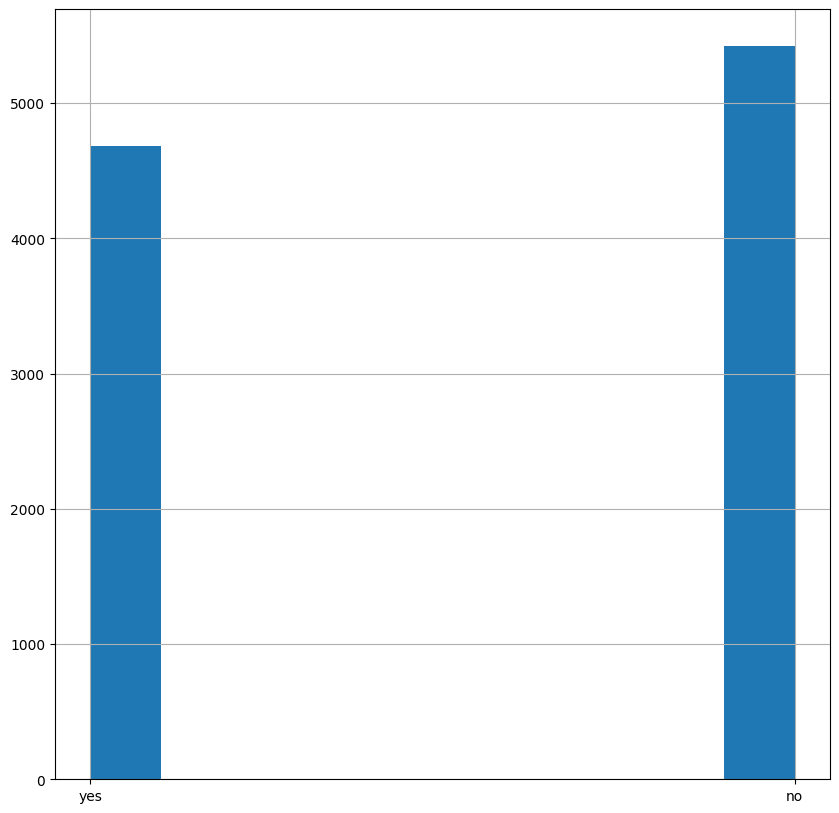

In [283]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

display(df['deposit'].value_counts())

df['deposit'].hist()

### Задания 2 и 3

In [284]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

display(df['age'].max())

df['duration'].min()

95

2

### Задания 4 и 5

In [285]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
import plotly.express as px

fig = px.bar(df['job'].value_counts())

display(fig)

mar = px.bar(df['marital'].value_counts())

display(mar)

display(px.bar(df['education'].value_counts()))

print('количество месяцев, в которые проводилась рекламная кампания:', df['month'].nunique())

display(px.bar(df['month'].value_counts()))

print('количество рабочих специальностей, представленных в датасете:', df['job'].nunique())

display(px.bar(df['job'].value_counts()))




количество месяцев, в которые проводилась рекламная кампания: 12


количество рабочих специальностей, представленных в датасете: 11


### Задание 6

<AxesSubplot: xlabel='poutcome'>

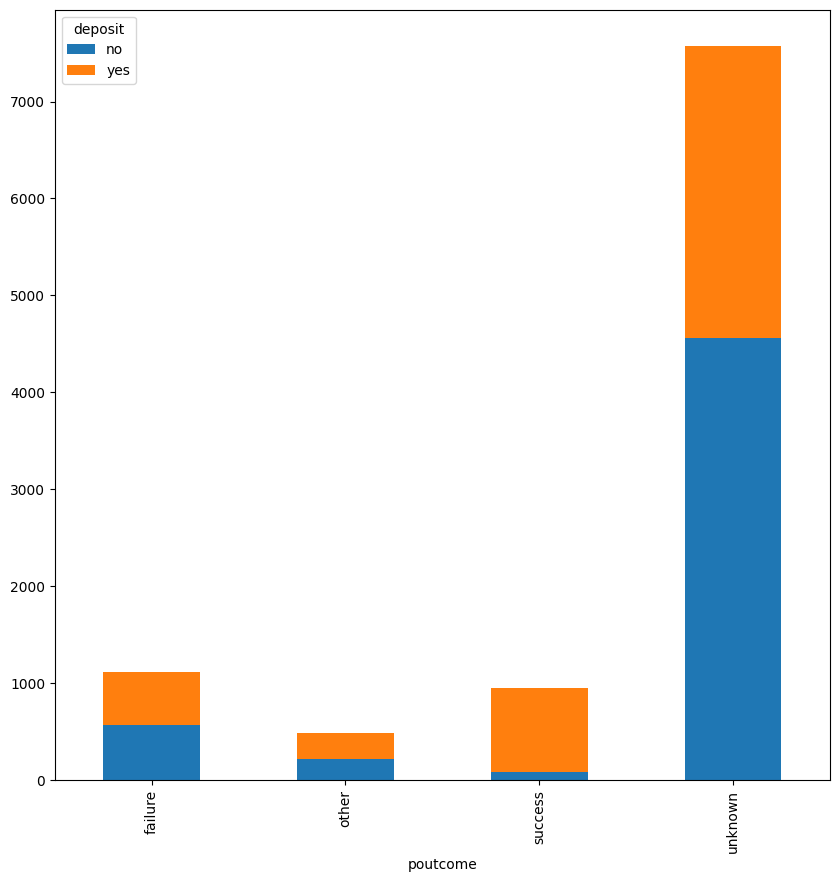

In [286]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

df.groupby('poutcome').sum()

types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')


### Задание 7

In [287]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

df.groupby('poutcome')['month'].value_counts()

poutcome  month
failure   may       335
          apr       150
          nov       139
          feb       127
          aug        84
          oct        62
          jun        48
          sep        46
          jul        42
          jan        39
          mar        26
          dec        11
other     may       113
          apr        64
          feb        55
          nov        40
          aug        36
          jan        36
          sep        31
          jun        28
          jul        26
          mar        20
          oct        20
          dec        12
success   aug       137
          may       117
          feb        93
          sep        91
          oct        90
          nov        85
          jun        84
          apr        77
          jul        64
          mar        42
          jan        37
          dec        28
unknown   may      2052
          jul      1286
          aug      1128
          jun       944
          apr       539


### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

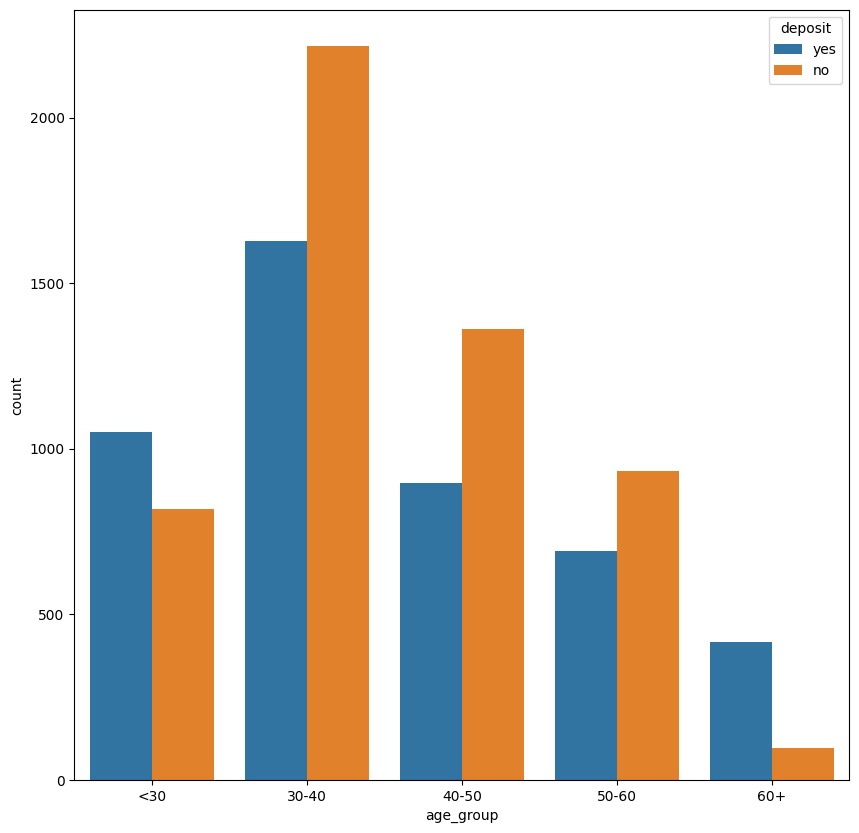

In [288]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

### Задания 9 и 10

In [289]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

mar = px.histogram(df, x='marital', color='deposit', height=900, width=500)

display(mar)

In [290]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования


display(px.histogram(df, x='education', color='deposit', height=800, width=600))

In [291]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

display(px.histogram(df, x='job', color='deposit', height=800))

### Задание 11

In [292]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

pd.crosstab(df['marital'], df['education'])

education,primary,secondary,tertiary
marital,,,
divorced,187,653,337
married,980,3119,1616
single,182,1745,1286


## Часть 3: Преобразование данных

### Задание 1

In [293]:
# преобразуйте уровни образования

le = LabelEncoder()

# Кодирование признака
df['education'] = le.fit_transform(df['education'])
display(df['education'].sum())

df.shape

11995

(10105, 18)

### Задания 2 и 3

In [294]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)

df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)

df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

display(round(df['deposit'].std(), 3))

df['default'].mean() + df['housing'].mean() + df['loan'].mean()



0.499

0.6354280059376547

### Задание 4

In [295]:
#Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные: 'job';'marital';'contact';'month';'poutcome'.
#Создайте для них dummy-переменные и добавьте их в набор данных.

#Сколько теперь всего признаков в датасете, не считая целевую переменную?

df = pd.get_dummies(df)

df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

### Задания 5 и 6

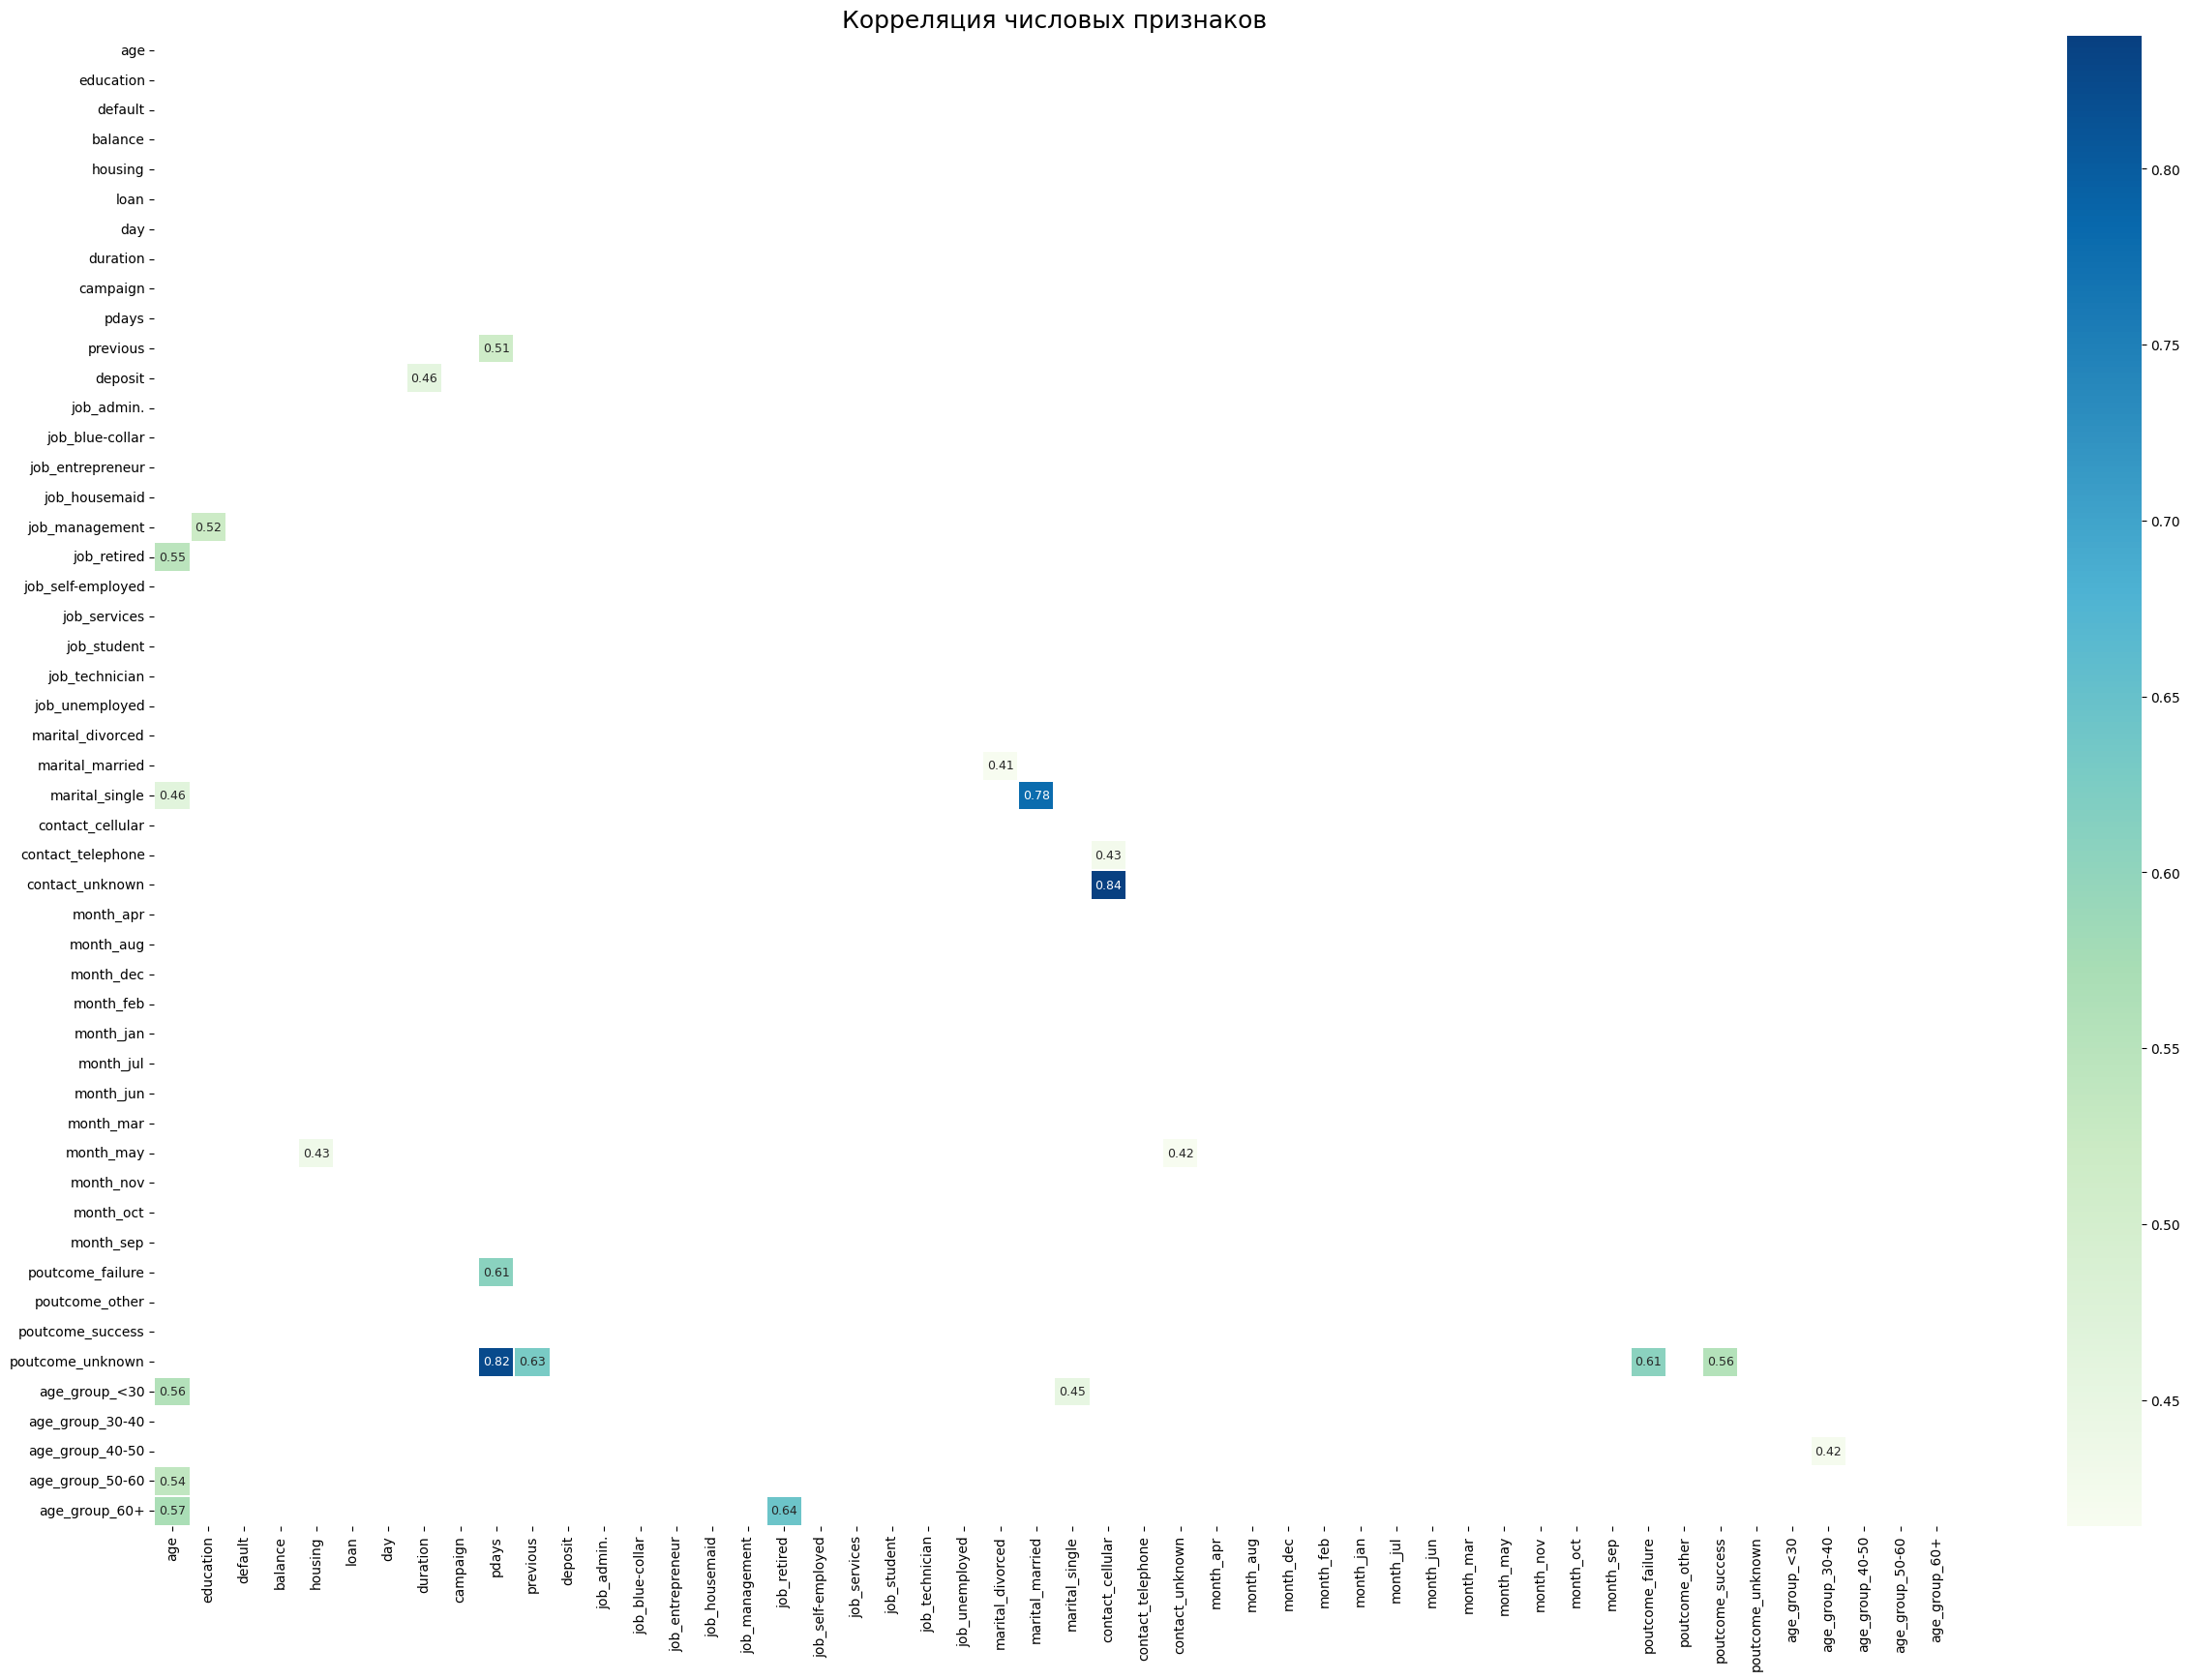

In [296]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.6):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(30, 20))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()
    
chart_correlation_heatmap(df, df.columns, 'Корреляция числовых признаков', correlation_threshold=.4)

### Задания 7 и 8

In [297]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [298]:
# рассчитайте необходимые показатели

X_test.shape

y_test.mean()

0.46326836581709147

### Задание 9

In [299]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
# Получаем названия фичей, чтобы сохранить и создать датафрейм только из них
cols_idxs = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]

X_train = features_df_new

X_test = pd.DataFrame(X_test, columns=features_df_new.columns)

X_train

,balance,housing,duration,campaign,pdays,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown,age_group_60+
6542,557.0,1,513,1,-1,0,1,0,0,0,0,0,0,1,0
4230,69.0,0,296,1,205,2,1,0,0,0,0,0,0,0,0
5079,0.0,1,399,2,358,5,0,0,0,1,0,0,0,0,0
2265,444.0,0,137,1,102,5,1,0,0,0,0,0,1,0,0
8386,1444.0,0,100,1,117,8,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6627,222.0,0,111,1,204,2,1,0,0,0,0,0,0,0,0
954,1777.0,1,796,5,154,1,1,0,0,0,0,0,0,0,0
2590,3324.0,0,122,1,92,3,1,0,0,0,0,0,1,0,1
6955,209.0,0,605,2,-1,0,1,0,0,0,0,0,0,1,0


### Задание 10

In [300]:
# нормализуйте данные с помощью minmaxscaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_df_new.columns)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_df_new.columns)

X_test_scaled['balance'].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [301]:
# обучите логистическую регрессию и рассчитайте метрики качества

from sklearn.metrics import accuracy_score

log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print(round(accuracy_score(y_test, y_pred), 2))



0.81


### Задания 2,3,4

In [302]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy', 
                            max_depth=6,
                            random_state=42)

dt.fit(X_train_scaled, y_train)

y_pred = dt.predict(X_test_scaled)

y_pred_x = dt.predict(X_train_scaled)

print('Train', round(accuracy_score(y_train, y_pred_x), 2))

print('Test', round(accuracy_score(y_test, y_pred), 2))



Train 0.81
Test 0.8


### Задание 5

In [303]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

grid_search.fit(X_train_scaled, y_train)

y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [304]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100,
                            criterion = 'gini',
                            min_samples_leaf = 5,
                            max_depth = 10,
                            random_state = 42)

rf.fit(X_train_scaled, y_train)

y_test_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [305]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_test_pred = gb.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))



f1_score на тестовом наборе: 0.81


### Задание 4

In [306]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_test_pred = stack.predict(X_test_scaled)
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))



precision на тестовом наборе: 0.81


### Задание 5

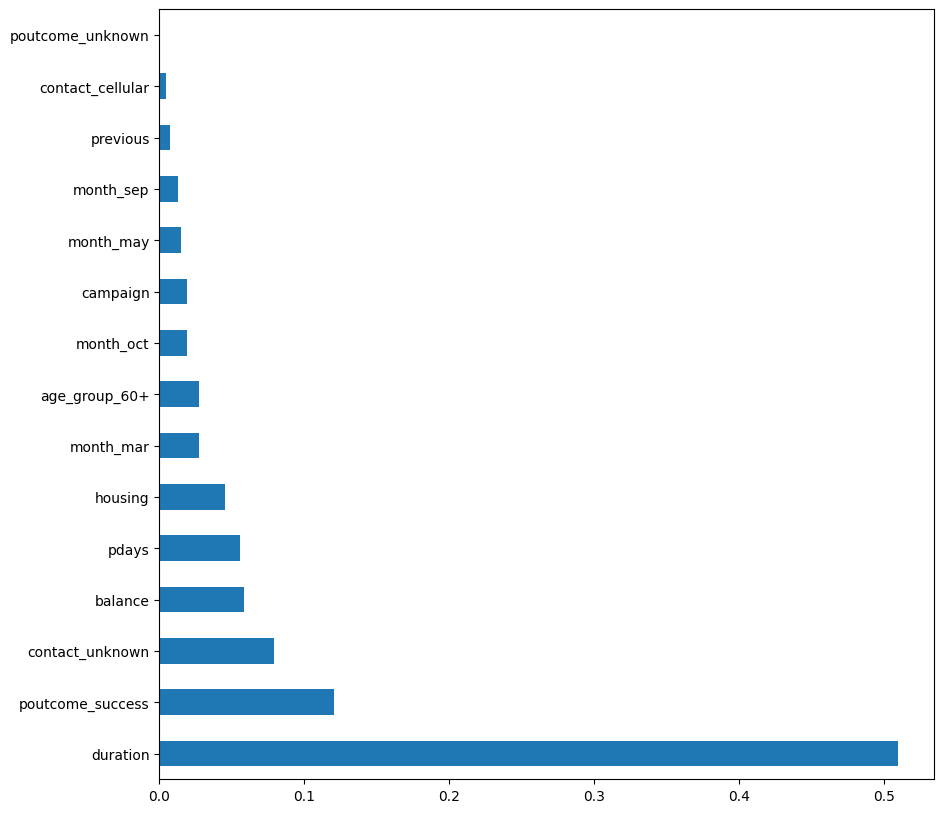

In [307]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(32).plot(kind='barh');

### Задания 6,7,8

In [308]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-10-25 23:11:19,222] A new study created in memory with name: RandomForestClassifier
[I 2023-10-25 23:11:19,900] Trial 0 finished with value: 0.8410450110166824 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8410450110166824.
[I 2023-10-25 23:11:20,795] Trial 1 finished with value: 0.86365780783142 and parameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.86365780783142.
[I 2023-10-25 23:11:21,630] Trial 2 finished with value: 0.8691837693874355 and parameters: {'n_estimators': 122, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8691837693874355.
[I 2023-10-25 23:11:22,745] Trial 3 finished with value: 0.8424689806816398 and parameters: {'n_estimators': 187, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8691837693874355.
[I 2023-10-25 23:11:23,429] Trial 4 finished with value: 0.8486087093224336 and parameters: {'n_esti

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
